AUC and F-scores for Cross Validation

Found this paper online

Reference: https://www.hpl.hp.com/techreports/2009/HPL-2009-359.pdf

about how to properly calculate F-score and AUC for cross validation. Now I want to test and use these 2 methods in a model. I chose the Iris dataset to begin with. Will apply this to imbalanced credit card dataset later.


Original code for testing: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

Excerpt from paper:
...
In conclusion, we urge the research community to consistently use $F_{tp,fp}$ and $AUC_{avg}$. IE - add all the tp and fp from each run before calculating the true F-measure score, don't use the average of the F-measure as this is like calculating an average of an average - see example below) . Be cautious when using software frameworks, as useful as they are for getting experiments done correctly and consistently. For example, as of version 3.6.1, WEKA’s Explorer GUI and Evaluation class use AUCmerge by default, and its Experimenter uses Favg, as do some other software frameworks.   
By contrast, AUC under cross-validation can be computed in two incompatible ways. The first is to sort the individual scores from all folds together into a single ROC curve and then compute the area of this curve, which we call $AUC_{merge}$. The other is to compute the AUC for each fold separately and then average over the folds:

Good: $AUC_{avg} = 1/k·\sum_{i=1}^k AUC(i)$

Example markdown: $$e^x=\sum_{i=0}^\infty \frac{1}{i!}x^i$$ 

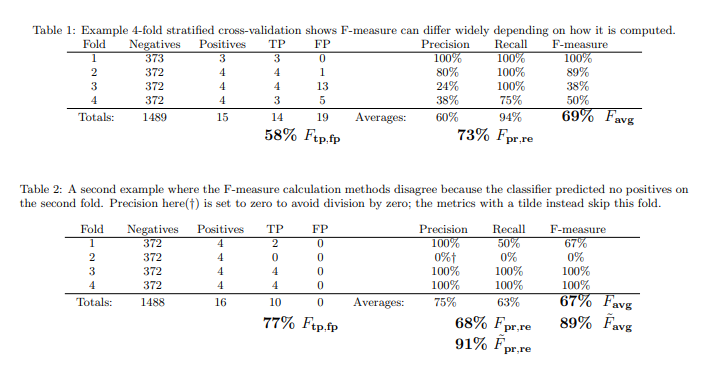

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split 

verbose = 0
# #############################################################################
# Data IO and generation

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.30, random_state = None)

In [2]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    gammas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    kernels = ['linear','rbf']
    #random_states = [1,2]
    param_grid = {'C': Cs, 'gamma' : gammas, 'kernel': kernels}
    grid_search = GridSearchCV(estimator=svm.SVC(random_state=random_state), param_grid=param_grid, scoring='roc_auc', cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [3]:
# create default model, no optimization
model = svm.SVC() 
model.fit(X_train, y_train) 
  
# print prediction results for Test dataset
predictions = model.predict(X_test) 
print(classification_report(y_test, predictions)) 


              precision    recall  f1-score   support

           0       0.80      0.25      0.38        16
           1       0.52      0.93      0.67        14

    accuracy                           0.57        30
   macro avg       0.66      0.59      0.52        30
weighted avg       0.67      0.57      0.51        30



Scores are very low, as expected. Cross validation should improve these scores

In [4]:
# defining parameter range for hyperparameter optimizations
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [100, 10, 1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf','linear']}  
inner_cv = KFold(n_splits=4, shuffle=True, random_state=None)
# setup the grid (f1)
grid = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, scoring='roc_auc', cv=inner_cv, refit = True, verbose = 0) 

# fitting the model for grid search - this may take a while
grid.fit(X_train, y_train) 
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

grid_predictions = grid.predict(X_test) 

# print classification report 
print(classification_report(y_test, grid_predictions)) 


{'C': 0.01, 'gamma': 100, 'kernel': 'linear'}
SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        16
           1       0.70      0.50      0.58        14

    accuracy                           0.67        30
   macro avg       0.68      0.66      0.65        30
weighted avg       0.67      0.67      0.66        30



Scores are better, maybe look at adding more parameters in the param_grid above

Next we will try a slightly different approach, using KFold cross validation to see if the results are consistent

In [5]:
# different approach
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
# initial model setup

# initial model results again
classifier = svm.SVC()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)
print(classification_report(y_test, predictions))

# run a grid search to get best parameters
BestParams = svc_param_selection(X_train, y_train, 5)
print('BestParams: ',BestParams)

#classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)
classifier = svm.SVC(**BestParams)

tprs = []
aucs = []
fscore = []
mean_fpr = np.linspace(0, 1, 100)


              precision    recall  f1-score   support

           0       0.80      0.25      0.38        16
           1       0.52      0.93      0.67        14

    accuracy                           0.57        30
   macro avg       0.66      0.59      0.52        30
weighted avg       0.67      0.57      0.51        30

BestParams:  {'C': 0.01, 'gamma': 0.0001, 'kernel': 'rbf'}


0 9 0 8
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         9
           1       0.47      1.00      0.64         8

    accuracy                           0.47        17
   macro avg       0.74      0.50      0.32        17
weighted avg       0.75      0.47      0.30        17

0 9 0 8
              precision    recall  f1-score   support

           0       1.00      0.00      0.00         9
           1       0.47      1.00      0.64         8

    accuracy                           0.47        17
   macro avg       0.74      0.50      0.32        17
weighted avg       0.75      0.47      0.30        17

8 0 9 0
              precision    recall  f1-score   support

           0       0.47      1.00      0.64         8
           1       1.00      0.00      0.00         9

    accuracy                           0.47        17
   macro avg       0.74      0.50      0.32        17
weighted avg       0.75      0.47      0.30       

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in longlong_scalars


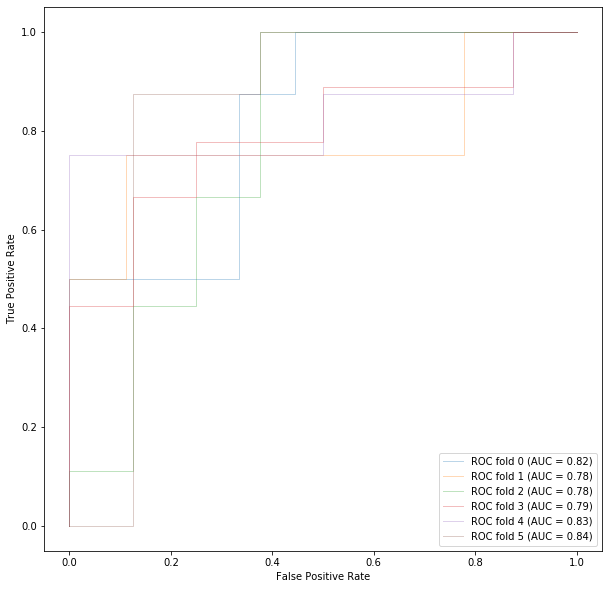

In [13]:
# used for the F tp,fp score !!!
tn_all = 0
fp_all = 0
fn_all = 0
tp_all = 0


fig, ax = plt.subplots(figsize=(10,10))
cv = StratifiedKFold(n_splits=6)
# run the model with the "best" params several times based on KFold parameters
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])

    
    # used for the F tp,fp score !!!
    Pred=classifier.predict(X[test])
    tn, fp, fn, tp = confusion_matrix(y[test], Pred).ravel()
    tn_all = tn_all + tn
    fp_all = fp_all + fp
    fn_all = fn_all + fn
    tp_all = tp_all + tp
    print(tn, fp, fn, tp)
    P = tp/(tp + fp)
    R = tp/(tp + fn)
    Fscore = (2 * P * R)/(P + R)

    
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
    fscore.append(Fscore)
    #print(classification_report(y[test], Pred))
    print(classification_report(y[test], Pred, zero_division=1)) # not sure what this zero_division is doing, other than supressing a warning


Show the results of our test

In [7]:
# used for the F tp,fp score !!! 
print(tn_all, fp_all, fn_all, tp_all)
P_all = tp_all/(tp_all + fp_all)
R_all = tp_all/(tp_all + fn_all)
Ftp_fp = (2 * P_all * R_all)/(P_all + R_all)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
AvgAuc = np.array(aucs).mean() # ***** this one!!!

F_avg = np.array(fscore).mean()

ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Merge (Mean) ROC (AUC = %0.3f (%0.3f) $\pm$ %0.2f)' % (mean_auc, AvgAuc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

print('F1_tp,fp value is %0.3f, F1_avg (has bias) is %0.3f' % (Ftp_fp, F_avg))

27 23 21 29
F1_tp,fp value is 0.569, F1_avg (has bias) is nan


Most of the time the $AUC_{merge}$ and the $AUC_{avg}$ values are close, also with the $F_{avg}$ and $F_{tp,fp}$ but sometimes they can be quite far off. Think this is due to: 
1) the bias inherent in the $F_{avg}$ computation 
2) the issues with calibration across folds in $AUC_{merge}$. However, stratification is another option, it can help alleviate the issues with $AUC_{merge}$. Using $AUC_{avg}$ will have none of these problems.


Conclusion:
Running the KFold validation shows some variation in the results, as expected. However, the new F-score and AUC are very repeatable

In [8]:
print('finished')

finished
